## Langmuir isotherm
This notebook shows an example use case modelling adsorption in MECSim. MECSim implements Longmuir isother for adsorption modelling. 

For example, if a specie `A` is undergoing an electron transfer reaction via adsorption, it can be modelled by assuming that there would be empty (filled) sites on the electrode where the specie `A` resides in. 

If `A` is being reduced `A+` via single electron transfer, adsoprtion part of the electron transfer is modelled by assuming that there are `S*` and `S*+` that faciliate the electron transfer via adsorption. 

As a result, we model the following reaction mechanism: $$ A^{+} + e \rightarrow A \\ A^{+} +S^{*}_{+} \rightarrow S^{*}$$

In [1]:
import numpy as np
from pymecsim import * 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
def test_langmuir_isotherm(exp, Keq, varname, speciename):
    """Utility function to plot the longmuir isotherm test
    
    Inputs:
    -------
        exp         :  A pymecsim experiment class
        Keq         :  Equilibrium constant of adsorption reaction
        varname     :  Concentration variable that s varied in a lograthim scale of (-4,4)
        speciename  : Adsorption specie name to be plotted on the Langmuir isotherm
        
        
    Output:
    -------
        theta       : array of shape (2,N) with theta values from a theoretical formula and computation using pymecsim
    """
    surface_species = []
    for s in exp.mechanism.species:
        if s.surface_confined:
            surface_species.append(s)
    C0 = np.logspace(-4.0,4.0, num=15)
    fig, ax = plt.subplots()
    theta_mecsim = []
    theta_theory = []
    for c in C0:
        sim = MECSIM(exp=exp)
        sim.set_parameter(varname, c)
        sim.solve()
        concs = sim.get_surface_concentrations()
        total_coverage = 0
        for s in surface_species:
            total_coverage += concs[s.name][-1]
        theta_mecsim.append(concs[speciename][-1]/total_coverage)
        theta_theory.append((Keq * c) / ( 1.0 + (Keq * c) ) )
        
    ax.plot(C0, theta_mecsim, label='pymecsim', lw=6)
    ax.plot(C0, theta_theory, label='Theory', lw=2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'[A] $mol/cm^3$')
    ax.set_ylabel(r'$\theta_{A*}$')
    ax.set_title('Langmuir Isotherm')
    ax.legend()
    plt.show()
    theta = np.column_stack((theta_mecsim, theta_theory))
    return theta

Charge Transfer : 1 A+ + 1 e <=> 1 A  ks= 0.00e+00, E0 = 0.00e+00, alpha = 5.00e-01
Chemical Reaction : 1 S+* + 1 A+ <=> 1 S*  kf= 1, kb= 1 



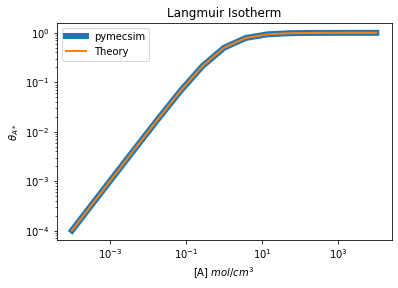

In [3]:
Aplus = Specie('A+', D=1e-5, C0='$C0')
A = Specie('A', D=1e-5, C0=0.0)
S_plus_star = Specie('S+*', D=0, C0=1e-12, surface_confined=True)
S_star = Specie('S*', D=0, C0=0, surface_confined=True)

R1 = ChargeTransfer([(Aplus,1),('e',1)],[(A,1)], ks=0.0, E0=0.0)
R2 = ChemicalReaction([(S_plus_star,1),(Aplus,1)],[(S_star,1)], kf=1, kb=1)

Keq = R2.kf/R2.kb
rxn = [R1, R2]

mech = Mechanism(rxn)
print(mech)

cv = DCVoltammetry(E_start = -0.5, E_rev=0.5, nu=0.1)
volt = Voltammetry(objs=[cv], N = 14)

exp = Experiment(mech, voltammetry=volt)
theta = test_langmuir_isotherm(exp, Keq, '$C0', 'S*')